In [1]:
import numpy as np
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.featurizer import KappaAngleFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline
from glob import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import mdtraj as md

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

You are still using msmtools from the deprecated Omnia channel. Please switch to conda-forge to catch future updates.
In order to do so please set conda-forge channel to highest priority by:

    conda config --add channels conda-forge

and update this package by:

    conda update msmtools




In [2]:
# 	    id	    feature	    strategy	cluster__n_clusters	tica__n_components	tica__lag_time	variance_cut__threshold	test_scores_mean	rank
# 3000	3927	pp_tor	    fixed	   56	                3	                384	            0.000656	3.450051	1.0
# 1921	2283	kappa_angle	fixed	   255	                2	                430	            0.000798	2.997726	2.0
# 1454	1812	kappa_angle	fixed	   755	                3	                401	            0.043183	2.996376	3.0
# 1674	2033	kappa_angle	fixed	   273	                2	                393	            0.000418	2.996359	4.0
# 1397	1755	kappa_angle	fixed	   101	                3	                77	            0.003388	2.995021	5.0

In [3]:
feature= 'kappa_angle'
trial_id = 1921
n_clusters = 255
n_components = 2
lag_time = 430
var_cut = 0.000798


## Get data

In [4]:
traj_paths = glob('/Users/robert_arbon/Datasets/DHFR/dcds/*.dcd')
topfile = '/Users/robert_arbon/Datasets/DHFR/dhfr_top.pdb'

len(traj_paths)

400

In [5]:
trajs  = [md.load(path, top=topfile) for path in traj_paths]

In [6]:
# trajs = [traj.superpose(trajs[0]) for traj in trajs]

## Calculate mask using MSMBuilder

In [7]:
featurizer = KappaAngleFeaturizer()
ftrajs = featurizer.fit_transform(trajs)

In [8]:
# Check for NaNs
traj_mask = [not np.any(np.isnan(ftraj)) for ftraj in ftrajs]

In [9]:
trajs = [traj for i, traj in enumerate(trajs) if traj_mask[i]]

In [10]:
traj_paths = [path for i, path in enumerate(traj_paths) if traj_mask[i]]

In [11]:
ftrajs = [ftraj for i, ftraj in enumerate(ftrajs) if traj_mask[i]]

In [12]:
variance = VarianceThreshold(threshold=var_cut)
variance.fit(ftrajs)
feat_mask = variance.get_support()

## Create pyEmma featurizer

In [13]:
def pyemma_featurizer(traj, mask, feat):
    ftraj = feat().partial_transform(traj)
    ftraj = ftraj[:, mask]
    return ftraj

In [14]:
from pyemma.coordinates.data import CustomFeature
my_feature = CustomFeature(pyemma_featurizer, mask=feat_mask, feat=KappaAngleFeaturizer, dim=int(np.sum(feat_mask)))

In [15]:
feat = coor.featurizer(topfile)

## Check custom featurizer

In [16]:
pyemma_ftraj = pyemma_featurizer(trajs[0], feat_mask, KappaAngleFeaturizer)

In [17]:
msmb_ftraj = variance.partial_transform(ftrajs[0])

In [18]:
print(pyemma_ftraj.shape)
print(msmb_ftraj.shape)
np.sum(pyemma_ftraj - msmb_ftraj)

(1000, 143)
(1000, 143)


0.0

In [19]:
feat.add_custom_feature(my_feature)

In [20]:
inp = coor.source(traj_paths, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',1000.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


number of trajectories =  396
trajectory length =  1000
trajectory time step =  1.001001001001001 ns
number of dimension =  143


## tICA 

In [21]:
print(lag_time, n_components)
tica_obj = coor.tica(inp, lag=lag_time, dim=n_components, kinetic_map=True)


430 2


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [22]:
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1

In [23]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

number of trajectories =  396
number of frames =  1000
number of dimensions =  2


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


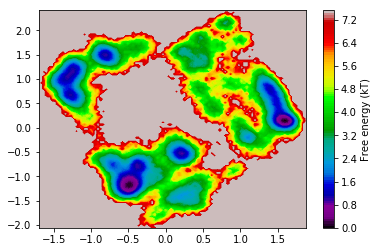

In [25]:
%matplotlib inline
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);


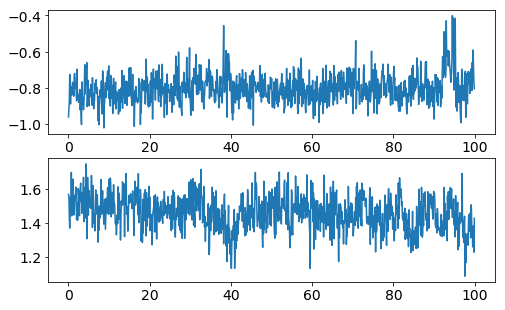

In [38]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
plt.figure(figsize=(8,5))
ax1=plt.subplot(211)
x = dt*np.arange(Y[0].shape[0])
plt.plot(x, Y[2][:,0]); ylabel=('IC 1'); xticks=([]); yticks=(np.arange(-8, 4, 2))
ax1=plt.subplot(212)
plt.plot(x, Y[2][:,1]); ylabel=('IC 2'); xticks=([]);  yticks=(np.arange(-6, 4, 2))


## Clustering

In [41]:
clustering = coor.cluster_mini_batch_kmeans(Y,k=n_clusters, max_iter=50)


23-08-17 15:24:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3] INFO     Cluster centers converged after 21 steps.


In [42]:
dtrajs = clustering.dtrajs


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


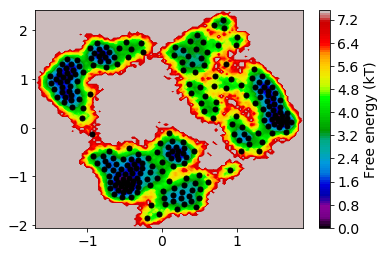

In [43]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

## Estimate MSM

In [46]:
msm_lag = 50
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


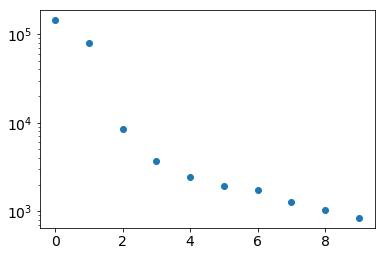

In [54]:
plt.scatter(np.arange(10), M.timescales(k=10))
plt.yscale('log')

## Coarse Grain

In [57]:
n_sets = 3
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships  # get PCCA memberships
# memberships over trajectory
dist_all = [np.hstack([pcca_dist[i,:][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(n_sets)]
mem_all = [np.hstack([membership[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(n_sets)]

In [58]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)


In [60]:
coor.save_trajs(inp, pcca_samples, outfiles=['pcca1_100samples.dcd','pcca2_100samples.dcd','pcca3_100samples.dcd'])

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/core/trajectory.py:1850: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/core/trajectory.py:1853: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


['pcca1_100samples.dcd', 'pcca2_100samples.dcd', 'pcca3_100samples.dcd']

## Hidden Markov Model

In [63]:
hmm = M.coarse_grain(n_sets)


In [64]:
hmm.stationary_distribution


array([ 0.44444444,  0.24494949,  0.31060606])

In [65]:
hmm.transition_matrix


array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])